# **Задание 2**

*Поработайте с датасетом affairs. Предскажите значение в колонке affairs по остальным факторам.*

*Сначала проведите разведочный анализ, а именно, исследуйте зависимость таргета от каждого фактора (или пары факторов).*

*Обучите линейную регрессию, посмотрите на качество кросс-валидации, затем разбейте данные на train и test.*

*Oбучите алгоритм на train и сделайте предсказания на train и test, выведите ошибки.*

*Посмотрите на матрицу корреляций факторов и целевой переменной.
Если есть пары сильно коррелирующих между собой факторов, удалите один из пары.*

*Если есть факторы, слабо коррелирующие с таргетом, удалите их.*

*Заново обучите алгоритм на обновленных данных. Как изменилось его качество?*

# 1. Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

# 2. Загружаем наш датасет

In [2]:
affairs_df = pd.read_csv('affairs.csv')
affairs_df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


В датасете приведены данные о внебрачных связях замужних женщин. Датасет поможет социологам отследить и предсказать какие факторы приводят к внебрачным связям замужних женщин.

Описание датасета:

- rate_marriage - оценка брака (1=очень_плохо, 2=плохо, 3=удовл, 4=хорошо, 5=очень_хорошо);
- age - возраст замужней женщины (17.5=младше 20, 22.0=20-24, 27.0=25-29, 32.0=30-34, 37.0=35-39, 42.0=40-44, 47.0=45-49, 52.0=50-54, 57.0=55_и_более);
- yrs_married - кол-во лет в браке (.125=мес_и_меньше, .417=4-6мес, .75 =6мес-1г, 1.5=1-2г, 4.0=3-5лет, 7.0=6-8лет, 10.0=9-11лет, 15.0=12лет_и_более);
- children - кол-во детей у замужней женщины;
- religious - насколько замужняя женщина религиозна (5=очень, 4=средне, 3=немного, 2=нет, 1=атеист);
- educ - уровень образования замужней женщины (9=старшая_школа, 12=выпускница_школы, 14=колледж, 16=выпускница_колледжа, 17=аспирантура, 20=ученая_степень);
- occupation - работа жены (1=студент, 2=полуквалифицированный/неквалифицированный рабочий, 3=умственный_труд, 4=квалифицированный_рабочий, 5=административная_работа, 6 = профессионал_со_степенью);
- occupation_husb -	работа мужа 1=студент, 2=полуквалифицированный/неквалифицированный рабочий, 3=умственный_труд, 4=квалифицированный_рабочий, 5=административная_работа, 6 = профессионал_со_степенью);
- affairs - как часто вы вступали во внебрачные половые отношения в течение последнего года (выводится среднее значение: 0=нет, 1=ендиножды, 2=дважды, 3=трижды, 7=4-10 раз, 12=ежемесячно/еженедельно/ежедневно).

# 3. Оценка данных

In [3]:
# выведем размерность нашего датасета:
affairs_df.shape

(6366, 9)

In [4]:
# выведем типы данных:
affairs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs          6366 non-null   float64
dtypes: float64(9)
memory usage: 447.7 KB


In [5]:
# выведем основные статистические показатели (целевая переменная - affairs):
affairs_df.describe().round(3)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000,6366.000,6366.000,6366.000,6366.000,6366.000,6366.000,6366.000,6366.000
mean,4.110,29.083,9.009,1.397,2.426,14.210,3.424,3.850,0.705
std,0.961,6.848,7.280,1.433,0.878,2.178,0.942,1.346,2.203
min,1.000,17.500,0.500,0.000,1.000,9.000,1.000,1.000,0.000
25%,4.000,22.000,2.500,0.000,2.000,12.000,3.000,3.000,0.000
50%,4.000,27.000,6.000,1.000,2.000,14.000,3.000,4.000,0.000
75%,5.000,32.000,16.500,2.000,3.000,16.000,4.000,5.000,0.485
max,5.000,42.000,23.000,5.500,4.000,20.000,6.000,6.000,57.600


# **Разведочный анализ**

Исследуем зависимость таргета от каждого фактора / пары факторов:

[Text(0.5, 1.0, 'Зависимость')]

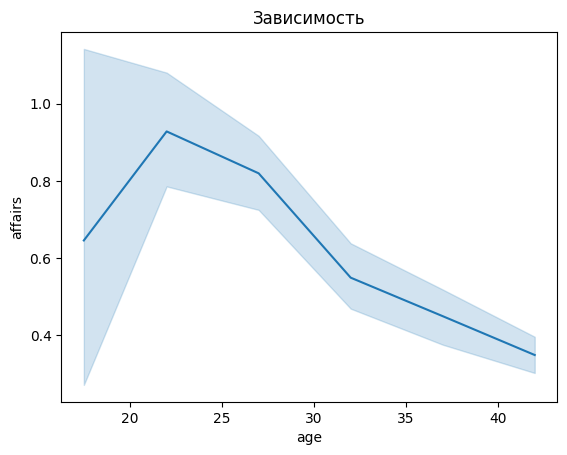

In [6]:
sns.lineplot(data=affairs_df, x='age', y='affairs').set(title='Зависимость')

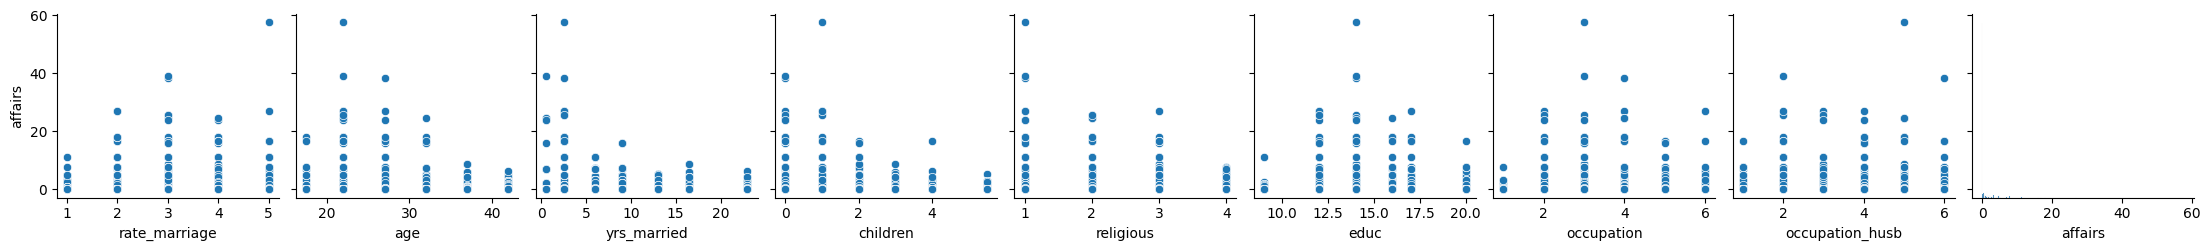

In [7]:
sns.pairplot(affairs_df, y_vars=['affairs'])

[Text(0.5, 1.0, 'Зависимость')]

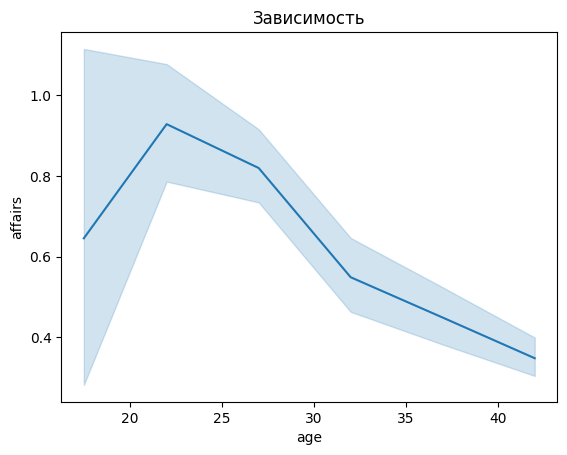

In [8]:
sns.lineplot(data=affairs_df, x='age', y='affairs').set(title='Зависимость')

[Text(0.5, 1.0, 'Зависимость')]

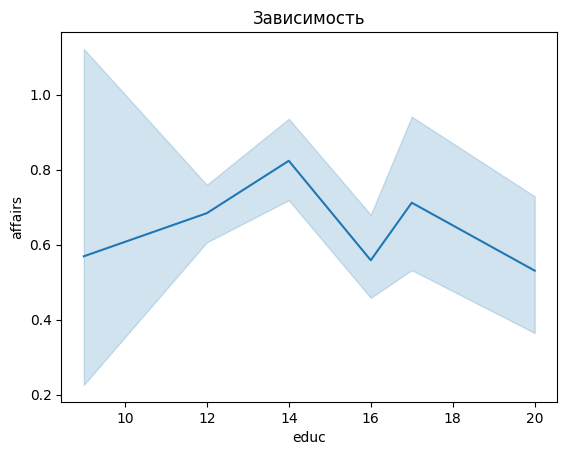

In [9]:
sns.lineplot(data=affairs_df, x='educ', y='affairs').set(title='Зависимость')

[Text(0.5, 1.0, 'Зависимость')]

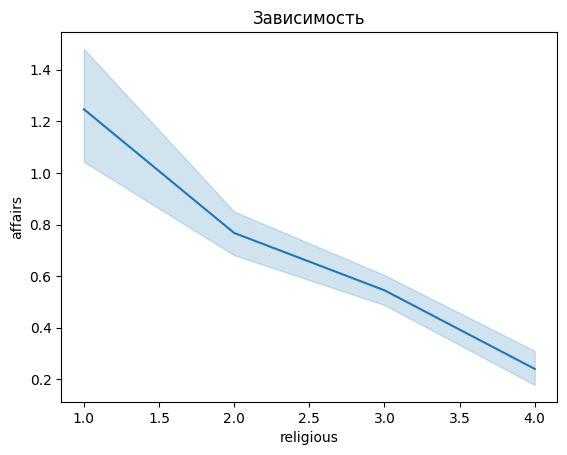

In [10]:
sns.lineplot(data=affairs_df, x='religious', y='affairs').set(title='Зависимость')

[Text(0.5, 1.0, 'Зависимость')]

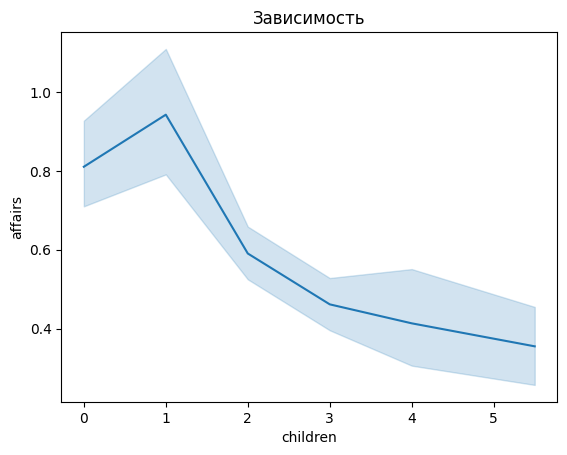

In [11]:
sns.lineplot(data=affairs_df, x='children', y='affairs').set(title='Зависимость')

[Text(0.5, 1.0, 'Зависимость')]

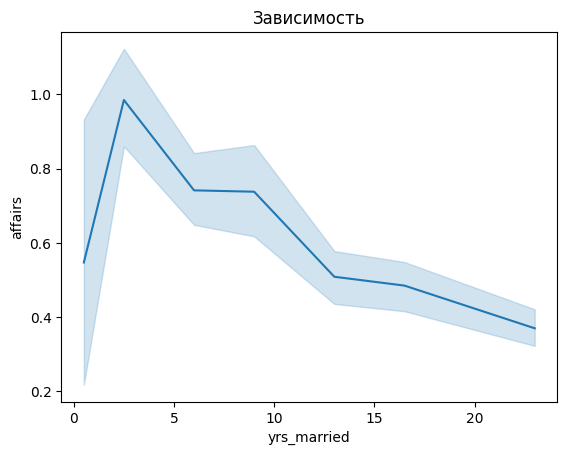

In [12]:
sns.lineplot(data=affairs_df, x='yrs_married', y='affairs').set(title='Зависимость')

[Text(0.5, 1.0, 'Зависимость')]

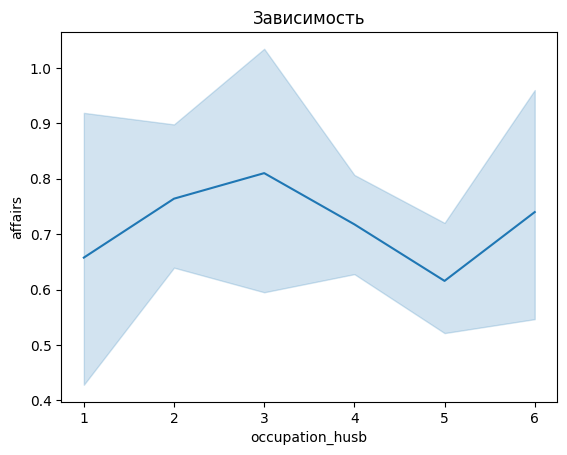

In [13]:
sns.lineplot(data=affairs_df, x='occupation_husb', y='affairs').set(title='Зависимость')

#**Построение модели**

Обучим линейную регрессию, посмотрим на качество кросс-валидации, затем разобьем данные на train и test:

In [14]:
X = affairs_df.drop(columns=['affairs']).copy()
y = affairs_df['affairs']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) # разобьем данныt на обучающую и тестовую выборки

regressor = LinearRegression() # создаем обьект класса Sklearn
regressor.fit(Xtrain, ytrain) # обучение модели

ypred_train = regressor.predict(Xtrain) # на основе нескольких независимых train перемнных (Xtrain) предскажем affairs (y)
ypred_test = regressor.predict(Xtest) # на основе нескольких независимых test перемнных (Xtest) предскажем affairs (y)

print('RMSE: ', np.sqrt(metrics.mean_squared_error(ytest, ypred_test))) # cреднеквадратическая ошибка
print('R2: ', np.round(metrics.r2_score(ytest, ypred_test), 2)) # коэффициент детерминации
print('MSE: ', "Train: ", mean_squared_error(ypred_train, ytrain) ** 0.5, "Test: ", mean_squared_error(ypred_test, ytest) ** 0.5) # cреднеквадратическая ошибка
print("Model train score: ", regressor.score(Xtrain, ytrain), '\nModel test score: ', regressor.score(Xtest, ytest))
print('\n', pd.DataFrame(data=regressor.coef_, index=Xtrain.columns, columns=['coef']))

RMSE:  2.1399602715898838
R2:  0.05
MSE:  Train:  2.142939223604753 Test:  2.1399602715898838
Model train score:  0.05484715217339786 
Model test score:  0.05278842767046832

                      coef
rate_marriage   -0.418556
age             -0.018418
yrs_married     -0.012225
children        -0.013963
religious       -0.252192
educ            -0.008942
occupation       0.026481
occupation_husb  0.007228


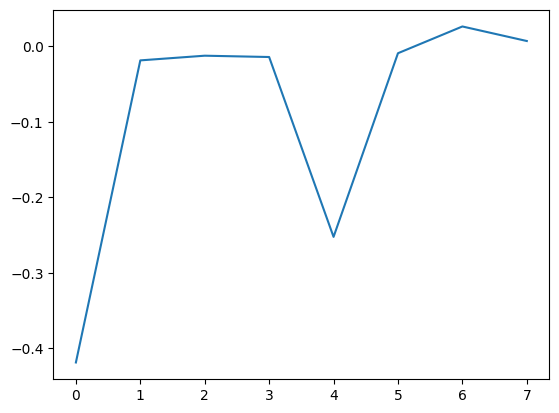

In [15]:
plt.plot(regressor.coef_)

Добавим ElasticNet:

In [16]:
# Посмотрим, что происходит при разных значениях параметра регуляризации ElasticNet:
from sklearn.linear_model import ElasticNet

for a in np.arange(0,0.2,0.01):
    regressor2 = ElasticNet(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
    print(regressor2.coef_,'\n')

<ipython-input-16-1e2757a4a6fa>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regressor2.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+04, tolerance: 2.474e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


alpha=0.0
Scores: 0.05278842767046832 4.57942996398305
[-0.41855599 -0.01841847 -0.01222493 -0.01396257 -0.25219208 -0.00894168
  0.02648142  0.00722791] 

alpha=0.01
Scores: 0.05231654671168007 4.581711340040137
[-0.41104259 -0.01850288 -0.0126278  -0.00885729 -0.24528305 -0.00633189
  0.01892109  0.00454793] 

alpha=0.02
Scores: 0.05178811607728784 4.584266113600463
[-0.4035916  -0.01839884 -0.01318872 -0.00378102 -0.23847043 -0.00381164
  0.01143763  0.00185665] 

alpha=0.03
Scores: 0.051197619165387453 4.587120955465776
[-0.3963047  -0.01836631 -0.01351673 -0.         -0.23160975 -0.00140421
  0.00386084  0.        ] 

alpha=0.04
Scores: 0.05087023423869663 4.588703744767386
[-0.38936642 -0.0184251  -0.01329882 -0.         -0.22455548 -0.
  0.          0.        ] 

alpha=0.05
Scores: 0.050790003353711866 4.589091632467947
[-0.38243331 -0.01841277 -0.01321347 -0.         -0.21759184 -0.
  0.          0.        ] 

alpha=0.06
Scores: 0.05067458506924949 4.589649638689259
[-0.3755670

In [17]:
# Видим, что регуляризация ElasticNet зануляет некоторые веса и таким образом производит отбор признаков.
# Подберем оптимальное значение параметра регуляризации по кросс-валидации:

from sklearn.linear_model import ElasticNetCV

n_alphas = 200
alphas = np.linspace(0.1, 1.2, n_alphas)

elastic_cv = ElasticNetCV(alphas=alphas,
                          cv=3, random_state=17)
elastic_cv.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

ElasticNetCV(alphas=array([0.1       , 0.10552764, 0.11105528, 0.11658291, 0.12211055,
       0.12763819, 0.13316583, 0.13869347, 0.14422111, 0.14974874,
       0.15527638, 0.16080402, 0.16633166, 0.1718593 , 0.17738693,
       0.18291457, 0.18844221, 0.19396985, 0.19949749, 0.20502513,
       0.21055276, 0.2160804 , 0.22160804, 0.22713568, 0.23266332,
       0.23819095, 0.24371859, 0.24924623, 0.25477387, 0.26030151,
       0....
       1.0120603 , 1.01758794, 1.02311558, 1.02864322, 1.03417085,
       1.03969849, 1.04522613, 1.05075377, 1.05628141, 1.06180905,
       1.06733668, 1.07286432, 1.07839196, 1.0839196 , 1.08944724,
       1.09497487, 1.10050251, 1.10603015, 1.11155779, 1.11708543,
       1.12261307, 1.1281407 , 1.13366834, 1.13919598, 1.14472362,
       1.15025126, 1.15577889, 1.16130653, 1.16683417, 1.17236181,
       1.17788945, 1.18341709, 1.18894472, 1.19447236, 1.2       ]),
             cv=3, random_state=17)

Найденный параметр регуляризации:

In [18]:
elastic_cv.alpha_

0.26582914572864325

Обучим модель с найденным параметром регуляризации:

In [19]:
regressor2 = ElasticNet(alpha=elastic_cv.alpha_)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('alpha={}'.format(a))
print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
print(regressor2.coef_,'\n')

alpha=0.19
Scores: 0.042111820467171546 4.6310475501367
[-0.24764909 -0.01796876 -0.01148049 -0.         -0.08495771 -0.
  0.          0.        ] 



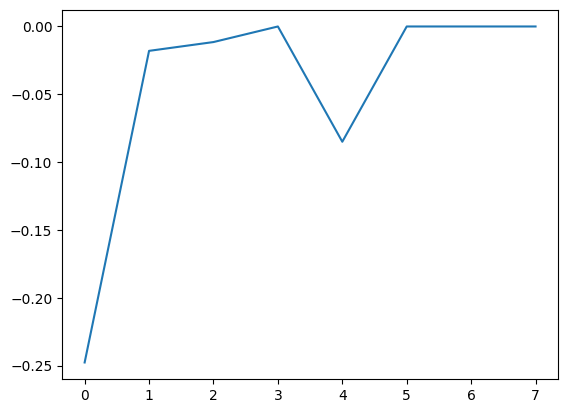

In [20]:

plt.plot(regressor2.coef_)

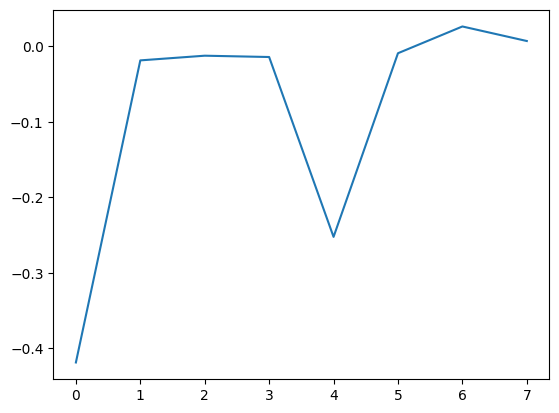

In [21]:
plt.plot(regressor.coef_)

In [22]:
ytrain

471     3.230769
5327    0.000000
3375    0.000000
3570    0.000000
4155    0.000000
          ...   
3772    0.000000
5191    0.000000
5226    0.000000
5390    0.000000
860     1.947825
Name: affairs, Length: 5092, dtype: float64

In [23]:
# p_value
# Чем меньше p_value, тем лучше. Если p_value большой, значит на выборку что-то повлияло:
X_incl_const = sm.add_constant(Xtrain)
model_sm = sm.OLS(ytrain, X_incl_const)
results = model_sm.fit()
org_coef = pd.DataFrame({'coef': round(results.params, 4), 'p-value': round(results.pvalues, 4)})
org_coef

,coef,p-value
const,3.7219,0.0000
rate_marriage,-0.4186,0.0000
age,-0.0184,0.0702
yrs_married,-0.0122,0.2671
children,-0.0140,0.6773
religious,-0.2522,0.0000
educ,-0.0089,0.5712
occupation,0.0265,0.4511
occupation_husb,0.0072,0.7538


In [24]:
# BIC
print('BIC - ', results.bic)
print('R2 - ', results.rsquared)
print('R2 (adjusted)  - ', results.rsquared_adj)

BIC -  22289.313229857213
R2 -  0.05484715217339786
R2 (adjusted)  -  0.053359600966903176


Выведем ошибки:

Text(0, 0.5, 'Residuals')

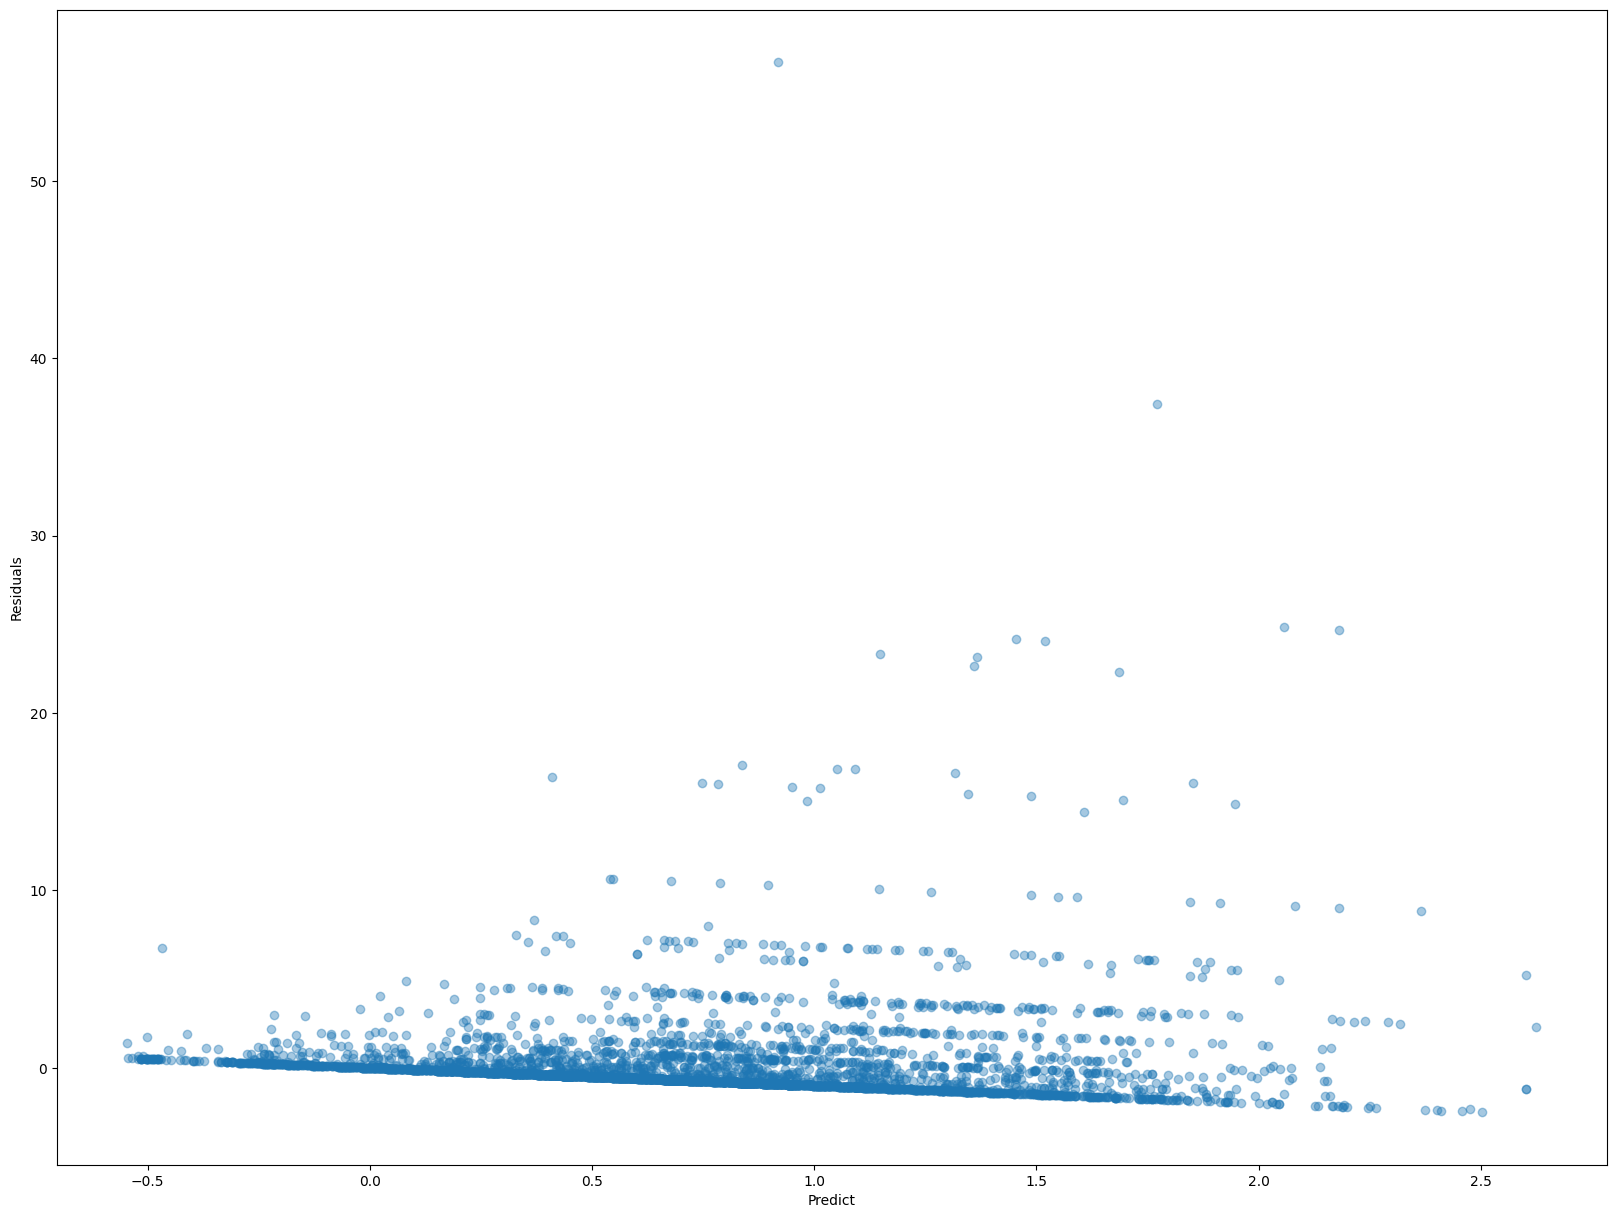

In [25]:
plt.figure(figsize=(20, 15))
plt.scatter(x=results.fittedvalues, y=results.resid, alpha=0.4)
plt.xlabel('Predict')
plt.ylabel('Residuals')

Посмотрим на матрицу корреляций факторов и целевой переменной:

- Если есть пары сильно коррелирующих между собой факторов, удалим один из пары.

- Если есть факторы, слабо коррелирующие с таргетом, удалим их.

In [26]:
def PrintCorr(dataset):
    plt.figure(figsize=(12,9))
    corr = dataset.corr()
    sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',
                mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

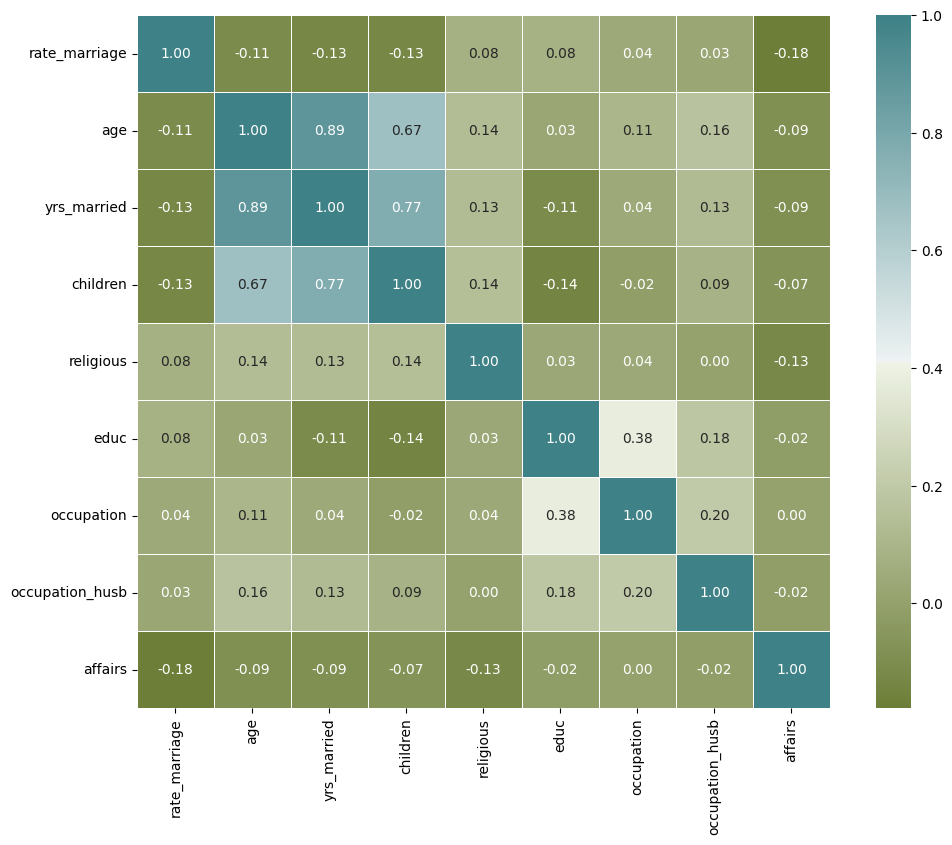

In [27]:
PrintCorr(affairs_df)

# - сильная положительная корреляция:
#  'occupation' & 'educ' (профессия жены коррелирует с образованием жены)
#  'occupation' & 'occupation_husb' (профессия мужа коррелирует с профессией жены)
#  'occupation_husb' & 'educ' (профессия мужа коррелирует с образованием жены)

#  'age' & 'occupation_husb' (профессия мужа коррелирует с возрастом жены)
#  'age' & 'religious' (религиозность жены коррелирует с возрастом жены)

#  'age' & 'yrs_married' (кол-во лет в браке коррелирует с возрастом жены)
#  'age' & 'children' (возраст жены коррелирует с образованием жены)
#  'children' & 'yrs_married' (профессия жены коррелирует с образованием жены)

#  'occupation_husb' & 'yrs_married' (профессия мужа коррелирует с кол-м лет в браке)
#  'religious' & 'yrs_married' (профессия жены коррелирует с образованием жены)

#  'religious' & 'children' (профессия жены коррелирует с образованием жены)

# - сильная отрицательная корреляция в парах:
#  'yrs_married' & 'rate_marriage'
#  'yrs_married' & 'religious'
#  'age' & 'rate_marriage'

# - сильная отрицательная корреляция с таргетом:
#  'affairs' & 'rate_marriage' (чем выше оценка брака, тем ниже кол-во внебрачных связей)

# - корреляция полностью отсутствует:
#  'affairs' & 'occupation'

In [28]:
# VIF (Мультиколлинеарность):
# Корреляция отсутствует: vif = 1
# Умеренная коррреляция: 1 < vif <= 5
# Высокая коррреляция: 5 < vif <= 7.5
# Очень высокая коррреляция: более 7.5

vif = [variance_inflation_factor(exog=X_incl_const.values, exog_idx=i) for i in range (X_incl_const.shape[1])]
pd.DataFrame({'corf_name': X_incl_const.columns, 'vif':np.around(vif, 2)})

,corf_name,vif
0,const,98.50
1,rate_marriage,1.04
2,age,5.37
3,yrs_married,7.10
4,children,2.56
5,religious,1.04
6,educ,1.30
7,occupation,1.21
8,occupation_husb,1.08


Заново обучим алгоритм на обновленных данных. (Как изменилось его качество?)

In [29]:
X = affairs_df.drop(columns=['affairs', 'yrs_married', 'occupation', 'educ', 'children', 'occupation_husb',]).copy() # ['affairs', 'yrs_married', 'occupation', 'educ', 'age', 'children', 'occupation_husb', 'religious']
y = affairs_df['affairs']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42) # разобьем данные на обучающую и тестовую выборки

regressor = LinearRegression() # создаем обьект класса Sklearn
regressor.fit(Xtrain, ytrain) # обучение модели

ypred_train = regressor.predict(Xtrain) # на основе нескольких независимых train перемнных (Xtrain) предскажем affairs (y)
ypred_test = regressor.predict(Xtest) # на основе нескольких независимых test перемнных (Xtest) предскажем affairs (y)

print('RMSE: ', np.sqrt(metrics.mean_squared_error(ytest, ypred_test))) # cреднеквадратическая ошибка
print('R2: ', np.round(metrics.r2_score(ytest, ypred_test), 2)) # коэффициент детерминации
print('MSE: ', "Train: ", mean_squared_error(ypred_train, ytrain) ** 0.5, "Test: ", mean_squared_error(ypred_test, ytest) ** 0.5) # cреднеквадратическая ошибка
print("Model train score: ", regressor.score(Xtrain, ytrain), '\nModel test score: ', regressor.score(Xtest, ytest))
print('\n', pd.DataFrame(data=regressor.coef_, index=Xtrain.columns, columns=['coef']))

RMSE:  2.143949131150719
R2:  0.05
MSE:  Train:  2.1436216491863678 Test:  2.143949131150719
Model train score:  0.05424508266499284 
Model test score:  0.049253955247514414

                    coef
rate_marriage -0.414867
age           -0.031285
religious     -0.255030


In [30]:
r2_score(ytrain,ypred_train), r2_score(ytest,ypred_test)
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

,0,0
0,rate_marriage,-0.414867
1,age,-0.031285
2,religious,-0.255030


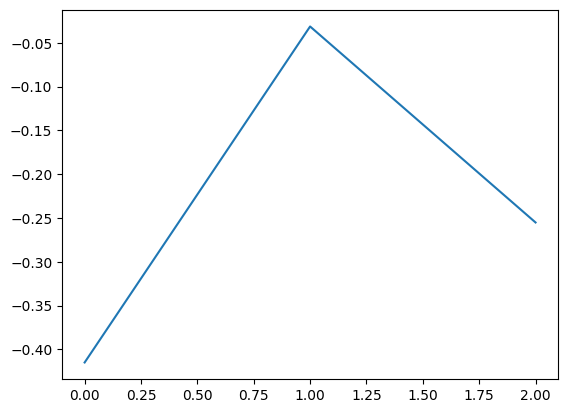

In [31]:
plt.plot(regressor.coef_)

In [32]:
# добавим ElasticNet
# Посмотрим, что происходит при разных значениях параметра регуляризации ElasticNet:
from sklearn.linear_model import ElasticNet

for a in np.arange(0,0.2,0.01):
    regressor2 = ElasticNet(alpha=a)
    regressor2.fit(Xtrain, ytrain)

    ypred2 = regressor2.predict(Xtest)

    print('alpha={}'.format(a))
    print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
    print(regressor2.coef_,'\n')

<ipython-input-32-2dca74307307>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regressor2.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+04, tolerance: 2.474e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


alpha=0.0
Scores: 0.049253955247514414 4.596517876961921
[-0.41486675 -0.03128546 -0.25503016] 

alpha=0.01
Scores: 0.049340647322284825 4.596098751714257
[-0.40769239 -0.03119433 -0.24770187] 

alpha=0.02
Scores: 0.04938728135556769 4.595873292803496
[-0.40058768 -0.03110272 -0.24046157] 

alpha=0.03
Scores: 0.04939512408334279 4.595835376013181
[-0.3935522  -0.03101068 -0.23330757] 

alpha=0.04
Scores: 0.04936540197997208 4.595979071777405
[-0.38658499 -0.03091822 -0.22623831] 

alpha=0.05
Scores: 0.04929930227494217 4.5962986402652355
[-0.37968508 -0.03082535 -0.21925226] 

alpha=0.06
Scores: 0.0491979743555403 4.596788524599266
[-0.37285152 -0.0307321  -0.21234793] 

alpha=0.07
Scores: 0.04906253111276804 4.597443344348612
[-0.3660834  -0.03063845 -0.20552387] 

alpha=0.08
Scores: 0.048894050233090125 4.598257889283761
[-0.3593798  -0.03054444 -0.19877867] 

alpha=0.09
Scores: 0.048693575438473746 4.599227113381427
[-0.35273982 -0.03045006 -0.19211094] 

alpha=0.1
Scores: 0.0484621

In [33]:
# Видим, что регуляризация ElasticNet зануляет некоторые веса и таким образом производит отбор признаков.
# Подберем оптимальное значение параметра регуляризации по кросс-валидации:

from sklearn.linear_model import ElasticNetCV

n_alphas = 200
alphas = np.linspace(0.1, 1.2, n_alphas)

elastic_cv = ElasticNetCV(alphas=alphas,
                          cv=3, random_state=17)
elastic_cv.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

ElasticNetCV(alphas=array([0.1       , 0.10552764, 0.11105528, 0.11658291, 0.12211055,
       0.12763819, 0.13316583, 0.13869347, 0.14422111, 0.14974874,
       0.15527638, 0.16080402, 0.16633166, 0.1718593 , 0.17738693,
       0.18291457, 0.18844221, 0.19396985, 0.19949749, 0.20502513,
       0.21055276, 0.2160804 , 0.22160804, 0.22713568, 0.23266332,
       0.23819095, 0.24371859, 0.24924623, 0.25477387, 0.26030151,
       0....
       1.0120603 , 1.01758794, 1.02311558, 1.02864322, 1.03417085,
       1.03969849, 1.04522613, 1.05075377, 1.05628141, 1.06180905,
       1.06733668, 1.07286432, 1.07839196, 1.0839196 , 1.08944724,
       1.09497487, 1.10050251, 1.10603015, 1.11155779, 1.11708543,
       1.12261307, 1.1281407 , 1.13366834, 1.13919598, 1.14472362,
       1.15025126, 1.15577889, 1.16130653, 1.16683417, 1.17236181,
       1.17788945, 1.18341709, 1.18894472, 1.19447236, 1.2       ]),
             cv=3, random_state=17)

In [34]:
# найденный параметр регуляризации:
elastic_cv.alpha_

0.25477386934673363

In [35]:
# обучим модель с найденным парматером регуляризации
regressor2 = ElasticNet(alpha=elastic_cv.alpha_)
regressor2.fit(Xtrain, ytrain)

ypred2 = regressor2.predict(Xtest)

print('alpha={}'.format(a))
print('Scores:', r2_score(ytest,ypred2), mean_squared_error(ytest,ypred2))
print(regressor2.coef_,'\n')

alpha=0.19
Scores: 0.041581585570294566 4.6336110466623355
[-0.25176459 -0.0288511  -0.09230201] 



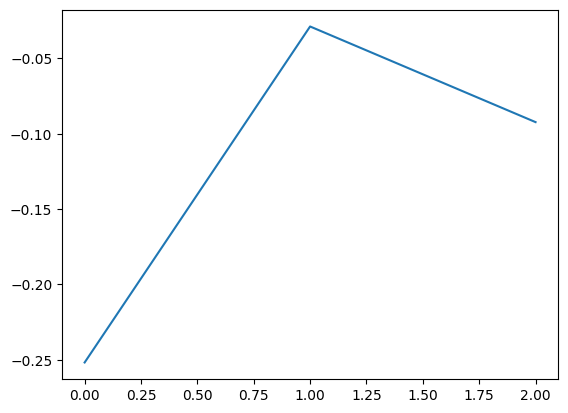

In [36]:
plt.plot(regressor2.coef_)

In [37]:
X_incl_const = sm.add_constant(Xtrain)
model_sm = sm.OLS(ytrain, X_incl_const)
results = model_sm.fit()
org_coef = pd.DataFrame({'coef': round(results.params, 4), 'p-value': round(results.pvalues, 4)})
org_coef

,coef,p-value
const,3.9503,0.0
rate_marriage,-0.4149,0.0
age,-0.0313,0.0
religious,-0.2550,0.0


In [38]:
# BIC
print('BIC - ', results.bic)
print('R2 - ', results.rsquared)
print('R2 (adjusted)  - ', results.rsquared_adj)

BIC -  22249.878709875004
R2 -  0.054245082664993394
R2 (adjusted)  -  0.05368744415241378


Text(0, 0.5, 'Residuals')

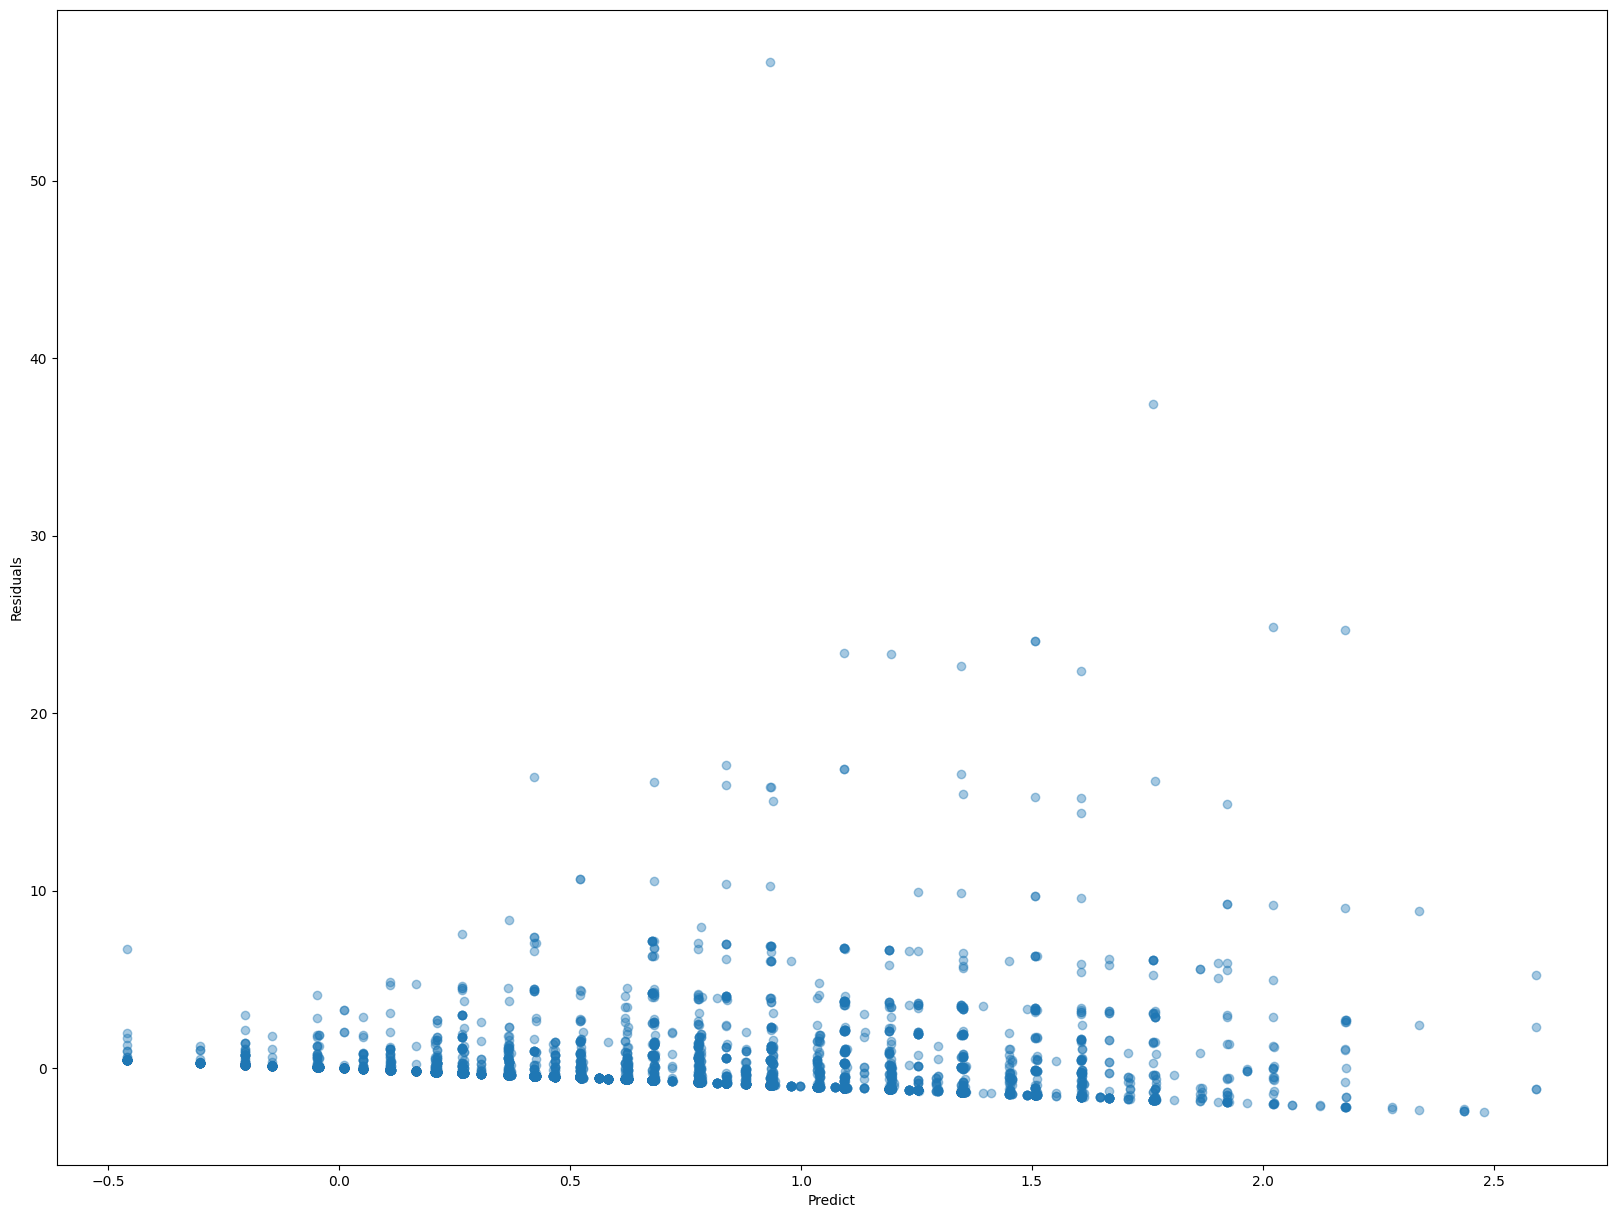

In [39]:
plt.figure(figsize=(20, 15))
plt.scatter(x=results.fittedvalues, y=results.resid, alpha=0.4)
plt.xlabel('Predict')
plt.ylabel('Residuals')

In [40]:
X_incl_const

,const,rate_marriage,age,religious
471,1.0,3.0,27.0,2.0
5327,1.0,4.0,22.0,1.0
3375,1.0,5.0,32.0,3.0
3570,1.0,4.0,42.0,1.0
4155,1.0,5.0,27.0,2.0
...,...,...,...,...
3772,1.0,3.0,32.0,1.0
5191,1.0,4.0,22.0,2.0
5226,1.0,5.0,27.0,1.0
5390,1.0,5.0,32.0,3.0
